In [45]:
import pandas as pd
train = pd.read_csv('/kaggle/input/amc-mavs/train.csv')
test = pd.read_csv('/kaggle/input/amc-mavs/test.csv')

# Exploratory Data Analysis (EDA)

This section scans the `train` and `test` DataFrames and shows:
- shapes and column lists
- data types and missing-value counts
- summary statistics and unique counts
- top value counts for categorical columns
- simple visualizations (histograms and bar plots)

In [47]:
print('Train shape:', train.shape)
print('Test shape:', test.shape)

print('Train columns:', train.columns.tolist())

print('Sample rows (train):')
display(train.head())

print('Target Price summary:')
display(train.price.describe())

print('\nTrain dtypes:')
print(train.dtypes)


Train shape: (75000, 4)
Test shape: (75000, 3)
Train columns: ['sample_id', 'catalog_content', 'image_link', 'price']
Sample rows (train):


,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


Target Price summary:


count    75000.000000
mean        23.647654
std         33.376932
min          0.130000
25%          6.795000
50%         14.000000
75%         28.625000
max       2796.000000
Name: price, dtype: float64


Train dtypes:
sample_id            int64
catalog_content     object
image_link          object
price              float64
dtype: object


##  Analysis of Price Distribution

Here we analyze the distribution of the `price` variable to understand its characteristics and prepare it for modeling.

---

### Initial Analysis (Raw Scale)

The plots of the raw price data reveal several key insights:

* **Extreme Right-Skew:** The price distribution is **highly right-skewed** (positively skewed). This is evident from the histogram where the vast majority of the data is concentrated in the first few bins on the far left.
* **Concentrated Low Prices:** The box plot and violin plot are squashed near zero, indicating that the median and interquartile range are very low. This confirms that most products in the dataset are inexpensive.
* **Numerous Outliers:** The box plot highlights a significant number of **outliers** at higher price points, which pull the mean upwards and stretch the x-axis, making the main distribution difficult to interpret.
* **Steep CDF:** The Cumulative Distribution Function (CDF) rises almost vertically and then flattens out, which shows that a very high percentage of the data (~95%) is found within a very small price range at the low end.


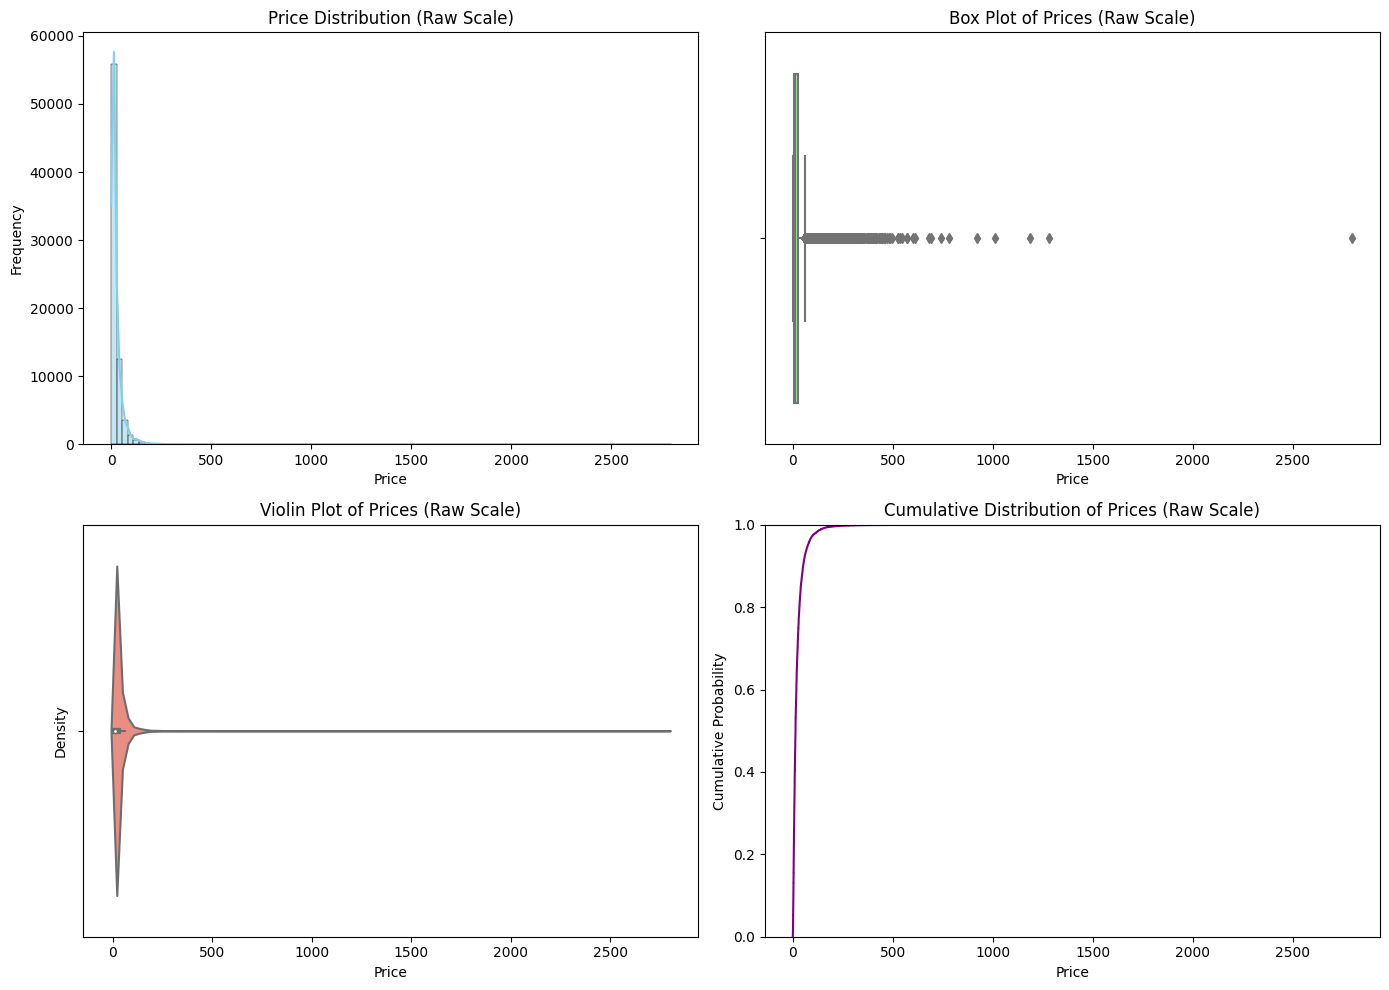

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- 1. Histogram ---
sns.histplot(train['price'], bins=100, kde=True, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title("Price Distribution (Raw Scale)")
axes[0, 0].set_xlabel("Price")
axes[0, 0].set_ylabel("Frequency")

# --- 2. Box Plot ---
sns.boxplot(x=train['price'], color='lightgreen', ax=axes[0, 1])
axes[0, 1].set_title("Box Plot of Prices (Raw Scale)")
axes[0, 1].set_xlabel("Price")
axes[0, 1].set_ylabel("")

# --- 3. Violin Plot ---
sns.violinplot(x=train['price'], inner="box", color='salmon', ax=axes[1, 0])
axes[1, 0].set_title("Violin Plot of Prices (Raw Scale)")
axes[1, 0].set_xlabel("Price")
axes[1, 0].set_ylabel("Density")

# --- 4. ECDF Plot ---
sns.ecdfplot(train['price'], color='purple', ax=axes[1, 1])
axes[1, 1].set_title("Cumulative Distribution of Prices (Raw Scale)")
axes[1, 1].set_xlabel("Price")
axes[1, 1].set_ylabel("Cumulative Probability")

# Adjust layout
plt.tight_layout()
plt.show()

### Log Transformation: The 'Why'

The severe skewness of the price data can negatively impact the performance of many machine learning algorithms, especially linear models (like Linear Regression) and distance-based algorithms (like K-Nearest Neighbors). To address this, we apply a **logarithmic transformation** ($y = \log(x+1)$). We add 1 to the price before taking the log to handle any items that might have a price of zero, as $\log(0)$ is undefined.

The key reasons for this transformation are:

1.  **Handling Skewness:** The log function compresses the range of large values more than it compresses small values. This pulls in the long right tail and makes the distribution more symmetric and **closer to a normal (Gaussian) distribution**.
2.  **Improving Model Performance:** Many models assume that features and/or the target variable are normally distributed. Using the log-transformed price can lead to a more stable, accurate, and reliable model.
3.  **Better Visualization:** After transformation, the data is more spread out across the axis, making it much easier to visualize patterns and relationships in subsequent plots.

After applying the log transformation, we expect to see a distribution that is much more bell-shaped, providing a better feature for our modeling phase. 

In [ ]:
train['log_price'] = np.log1p(train['price'])

# Create 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- 1. Histogram ---
sns.histplot(train['log_price'], bins=100, kde=True, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title("Log-Transformed Price Distribution (log1p)")
axes[0, 0].set_xlabel("log(price + 1)")
axes[0, 0].set_ylabel("Frequency")

# --- 2. Box Plot ---
sns.boxplot(x=train['log_price'], color='lightgreen', ax=axes[0, 1])
axes[0, 1].set_title("Box Plot of Log-Transformed Prices")
axes[0, 1].set_xlabel("log(price + 1)")
axes[0, 1].set_ylabel("")

# --- 3. Violin Plot ---
sns.violinplot(x=train['log_price'], inner="box", color='salmon', ax=axes[1, 0])
axes[1, 0].set_title("Violin Plot of Log-Transformed Prices")
axes[1, 0].set_xlabel("log(price + 1)")
axes[1, 0].set_ylabel("Density")

# --- 4. ECDF Plot ---
sns.ecdfplot(train['log_price'], color='purple', ax=axes[1, 1])
axes[1, 1].set_title("Cumulative Distribution of log(price + 1)")
axes[1, 1].set_xlabel("log(price + 1)")
axes[1, 1].set_ylabel("Cumulative Probability")

# Adjust layout
plt.tight_layout()
plt.show()


# Image Dataset EDA

Before training any vision model, it is important to understand the images in terms of size, shape, and format.  
The following analysis provides an overview of these properties and highlights issues that need to be addressed in preprocessing.

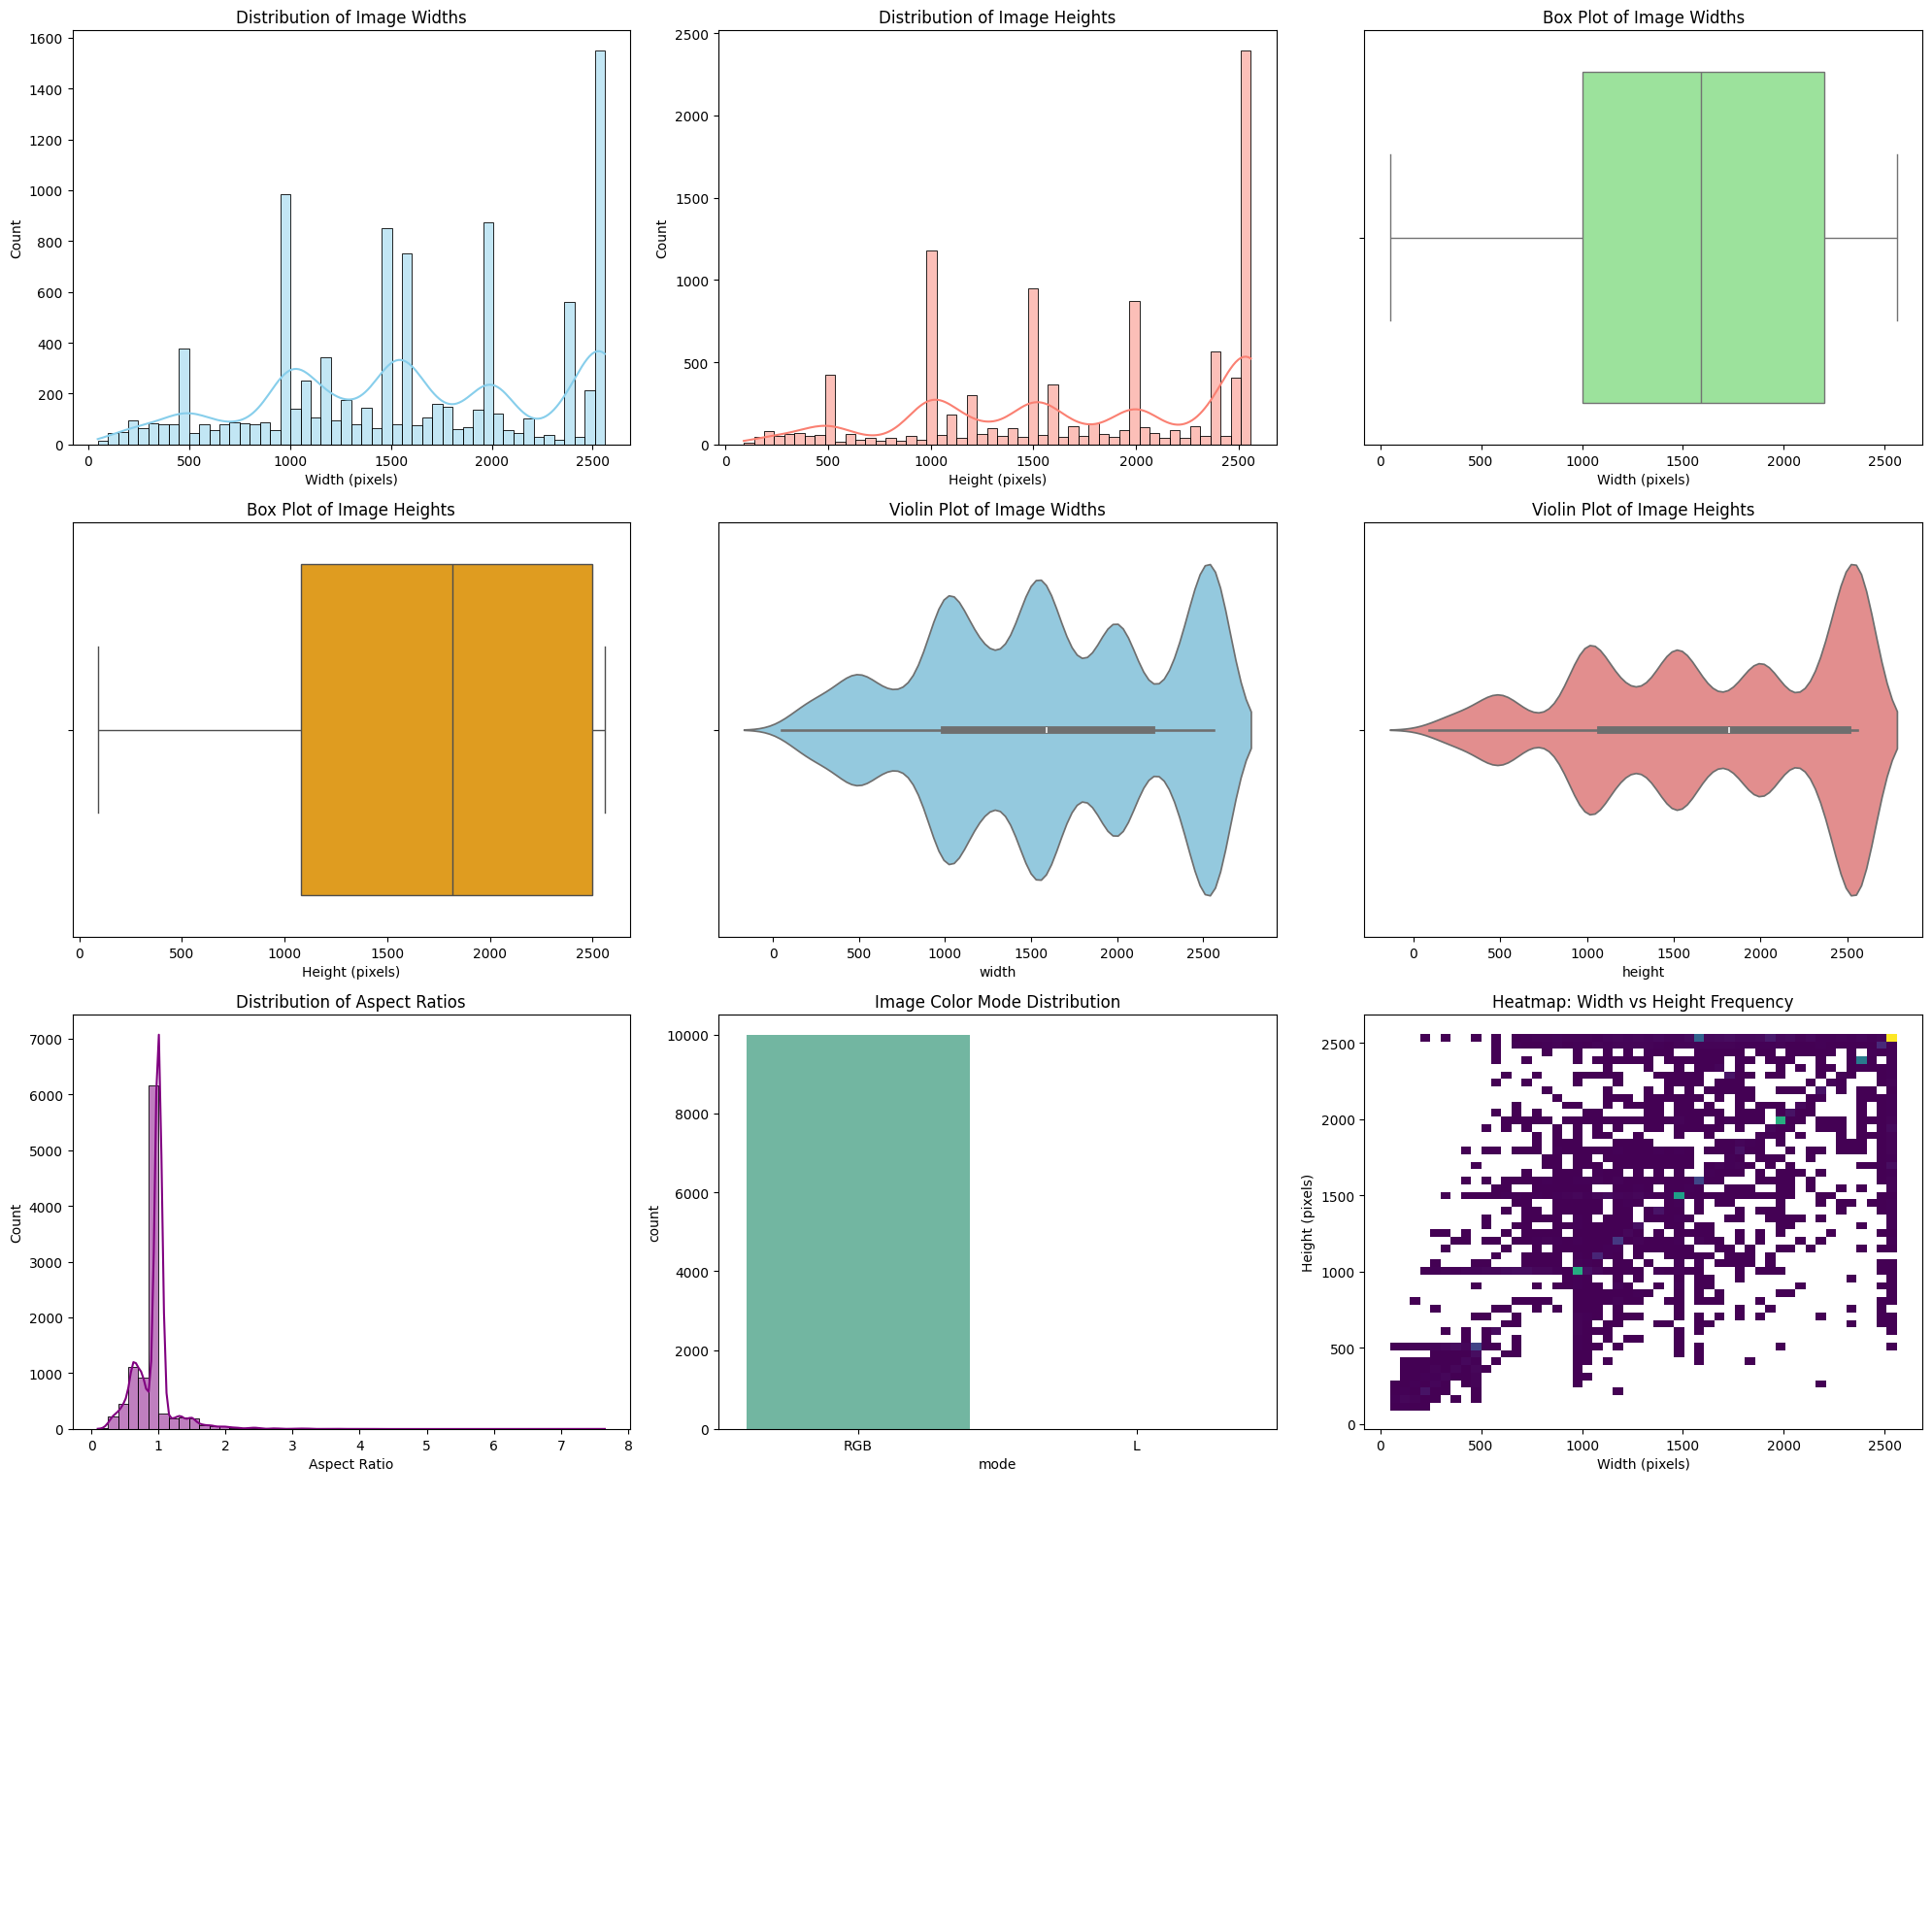

In [1]:
from IPython.display import Image, display
display(Image(filename="/kaggle/input/raw-data-analysis/image_analysis.png"))

## 1. Image Dimensions (Widths and Heights)

**Observations:**
- Most images fall into a handful of common pixel dimensions, suggesting they come from a few standardized sources.  
- There are clear outliers: some images are unusually small (possibly thumbnails or bad downloads) and some are very large (high-resolution product images or banners).  
- The violin plots indicate more than one "mode," so there are at least two or three dominant resolution groups.  
- For training, all images will need to be resized to a consistent target size. Outliers may need to be padded, cropped, or dropped.

---

## 2. Aspect Ratio

Aspect ratio (width ÷ height) shows whether images are square, portrait, or landscape.

**Observations:**
- A strong cluster around 1.0 confirms that square images dominate the dataset.  
- Portrait and landscape images are present, along with a few extreme ratios that may indicate stretched or corrupted files.  
- Simply resizing to a square will distort these non-square images. A padding strategy will preserve the aspect ratio more reliably.

---

## 3. Color Modes

**Observations:**
- The majority of images are RGB, which is compatible with most vision models.  
- A smaller number of images are grayscale (mode "L") or other formats (such as RGBA). These will need conversion to RGB for consistency.  
- If left unprocessed, channel inconsistencies will cause errors during model training.

---

## 4. Width vs Height Scatter

**Observations:**
- Most points align along the diagonal line, confirming that square images dominate.  
- Clusters off the diagonal correspond to portrait or landscape groups.  
- Outliers appear as isolated points with extreme resolutions. These cases may need manual inspection or exclusion.

---

## 5. Heatmap of Resolutions

**Observations:**
- Bright hotspots represent the most common width–height combinations (e.g., 256×256, 1024×1024).  
- Scattered points indicate rare or unusual resolutions.  
- Selecting a single target resolution (e.g., 224×224 or 256×256) would cover most images, while the remaining sizes could be resized or padded.

---

## Overall Notes

- The dataset is mostly consistent, but not completely clean.  
- Common sizes and square images form the majority, though outliers exist in both dimensions and aspect ratios.  
- RGB is the dominant mode, but grayscale images must be standardized to RGB.  
- Recommended preprocessing steps:
  1. Resize to a standard square resolution (512x512),  
  2. Use padding for non-square images to avoid distortion,  
  3. Inspect or remove extreme outliers.  

This analysis provides a clear view of dataset quality and guides the preprocessing pipeline needed for stable and efficient model training.

In [50]:
import torch, torchvision, platform
print('PyTorch:', torch.__version__, '| CUDA:', torch.cuda.is_available())
print('Torchvision:', torchvision.__version__)
print('Python:', platform.python_version())

# import torchvision.models as models
# resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
# import torchvision.models as models
# import torch.nn as nn
# import torch

# weights_path = "/kaggle/input/resnet/resnet50-0676ba61.pth"
# state_dict = torch.load(weights_path, map_location="cpu")

# resnet = models.resnet50()
# resnet.load_state_dict(state_dict)
# resnet.fc = nn.Identity()
# resnet = resnet.to(device).eval()

PyTorch: 2.6.0+cu124 | CUDA: True
Torchvision: 0.21.0+cu124
Python: 3.11.13


In [27]:
# ----------------------------
# Load Data
# ----------------------------
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

weight_units = ["oz","g","kg","lb","ml","l","fl oz"]
count_units  = ["count","other"]

# ----------------------------
# Price clipping
# ----------------------------
w_low, w_high = np.percentile(train_df[train_df['unit_clean'].isin(weight_units)]['price'], [1,99])
c_low, c_high = np.percentile(train_df[train_df['unit_clean'].isin(count_units)]['price'], [1,99])

print(f"Weight clip: {w_low:.2f} - {w_high:.2f}")
print(f"Count clip:  {c_low:.2f} - {c_high:.2f}")

def clip_price(row):
    if row['unit_clean'] in weight_units:
        return np.clip(row['price'], w_low, w_high)
    elif row['unit_clean'] in count_units:
        return np.clip(row['price'], c_low, c_high)
    return row['price']

train_df['price_clipped'] = train_df.apply(clip_price, axis=1)
train_df['log_price'] = np.log1p(train_df['price_clipped'])


Weight clip: 1.28 - 133.77
Count clip:  1.58 - 173.24


In [28]:
# ----------------------------
# Text preprocessing + SBERT (offline)
# ----------------------------

def clean_item_name(name):
    name = str(name).strip()
    tokens = name.split()
    if len(tokens) < 2 or re.match(r'^[^a-zA-Z]+$', name):
        return "misc"
    return name

train_df['text_input'] = train_df['item_name'].apply(clean_item_name)
test_df['text_input']  = test_df['item_name'].apply(clean_item_name)

print("🔹 Encoding item_name with SBERT...")
# ⚠️ Upload SBERT weights to Kaggle, e.g. /kaggle/input/sentencetransformersallminilml6v2
sbert = SentenceTransformer("/kaggle/input/sentencetransformersallminilml6v2")

train_text_emb = sbert.encode(train_df['text_input'].tolist(), show_progress_bar=True, normalize_embeddings=False)
test_text_emb  = sbert.encode(test_df['text_input'].tolist(),  show_progress_bar=True, normalize_embeddings=False)

def l2_normalize(mat):
    return mat / np.clip(norm(mat, axis=1, keepdims=True), 1e-8, None)

train_text_emb = np.nan_to_num(l2_normalize(train_text_emb))
test_text_emb  = np.nan_to_num(l2_normalize(test_text_emb))
text_dim = train_text_emb.shape[1]
print("Text dim:", text_dim)





🔹 Encoding item_name with SBERT...


Batches:   0%|          | 0/2344 [00:00<?, ?it/s]

Batches:   0%|          | 0/2344 [00:00<?, ?it/s]

Text dim: 384


In [30]:
# ----------------------------
# Image embeddings (ResNet50 offline)
# ----------------------------
img_transform = T.Compose([
    T.Resize((512,512)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

class ImageEmbDataset(Dataset):
    def __init__(self, df, images_dir):
        self.df = df.reset_index(drop=True)
        self.images_dir = images_dir

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        sid = str(self.df.iloc[idx]['sample_id'])
        img = None
        for ext in (".jpg",".jpeg",".png",".webp"):
            p = os.path.join(self.images_dir, sid + ext)
            if os.path.exists(p):
                try:
                    img = Image.open(p).convert("RGB")
                    break
                except: pass
        if img is None:
            return torch.zeros(3,512,512), 1
        return img_transform(img), 0

@torch.no_grad()
def extract_img_embeddings(df, images_dir):
    ds = ImageEmbDataset(df, images_dir)
    dl = DataLoader(ds, batch_size=32, shuffle=False, num_workers=2)

    # ⚠️ upload resnet50 weights to Kaggle dataset
    weights_path = '/kaggle/input/resnet/resnet50-0676ba61.pth'
    state_dict = torch.load(weights_path, map_location="cpu")

    resnet = models.resnet50()
    resnet.load_state_dict(state_dict)
    resnet.fc = nn.Identity()
    resnet = resnet.to(device).eval()

    feats_all, miss_all = [], []
    for imgs, miss in tqdm(dl, desc=f"Extracting {os.path.basename(images_dir)}"):
        imgs = imgs.to(device)
        feats = resnet(imgs).cpu().numpy()
        feats_all.append(feats)
        miss_all.append(miss.numpy())
    feats_all = np.vstack(feats_all).astype(np.float32)
    miss_all = np.concatenate(miss_all)
    feats_all[miss_all==1] = 0.0
    return feats_all

print("🖼 Extracting train image embeddings...")
train_img_emb = extract_img_embeddings(train_df, IMAGES_TRAIN_DIR)
print("🖼 Extracting test image embeddings...")
test_img_emb  = extract_img_embeddings(test_df,  IMAGES_TEST_DIR)
img_dim = train_img_emb.shape[1]
print("Image dim:", img_dim)

🖼 Extracting train image embeddings...


Extracting images_train_resized: 100%|██████████| 2344/2344 [22:40<00:00,  1.72it/s]


🖼 Extracting test image embeddings...


Extracting images_test_resized: 100%|██████████| 2344/2344 [22:43<00:00,  1.72it/s]


Image dim: 2048


In [35]:
df_w = train_df[train_df['unit_clean'].isin(weight_units)].copy()
df_c = train_df[train_df['unit_clean'].isin(count_units)].copy()

Xw_num = np.nan_to_num(df_w[['value_in_grams','log_value_in_grams','value_imputed_flag']].values)
Xc_num = np.nan_to_num(df_c[['value','value_imputed_flag']].values)
yw, yc = df_w['log_price'].values, df_c['log_price'].values

text_w, img_w = train_text_emb[df_w.index], train_img_emb[df_w.index]
text_c, img_c = train_text_emb[df_c.index], train_img_emb[df_c.index]


In [36]:
# ----------------------------
# Dataset
# ----------------------------
class MultiModalDataset(Dataset):
    def __init__(self, X_num, X_text, X_img, y=None):
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.X_txt = torch.tensor(X_text, dtype=torch.float32)
        self.X_img = torch.tensor(X_img, dtype=torch.float32)
        self.y = None if y is None else torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X_num)
    def __getitem__(self, i):
        if self.y is None: return self.X_num[i], self.X_txt[i], self.X_img[i]
        return self.X_num[i], self.X_txt[i], self.X_img[i], self.y[i]

# ----------------------------
# More complex multimodal model
# ----------------------------
class MultiModalWideDeep(nn.Module):
    def __init__(self, num_num_features, text_dim, img_dim):
        super().__init__()
        self.num_branch = nn.Sequential(
            nn.Linear(num_num_features, 64),
            nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.25)
        )
        self.text_branch = nn.Sequential(
            nn.Linear(text_dim, 256),
            nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU()
        )
        self.img_branch = nn.Sequential(
            nn.Linear(img_dim, 1024),
            nn.BatchNorm1d(1024), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU()
        )
        self.head = nn.Sequential(
            nn.Linear(64+64+128, 128),
            nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x_num, x_text, x_img):
        n, t, i = self.num_branch(x_num), self.text_branch(x_text), self.img_branch(x_img)
        return self.head(torch.cat([n,t,i], dim=1)).squeeze()

In [37]:
# ----------------------------
# Dataset
# ----------------------------
class MultiModalDataset(Dataset):
    def __init__(self, X_num, X_text, X_img, y=None):
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.X_txt = torch.tensor(X_text, dtype=torch.float32)
        self.X_img = torch.tensor(X_img, dtype=torch.float32)
        self.y = None if y is None else torch.tensor(y, dtype=torch.float32)

    def __len__(self): return len(self.X_num)

    def __getitem__(self, i):
        if self.y is None:
            return self.X_num[i], self.X_txt[i], self.X_img[i]
        return self.X_num[i], self.X_txt[i], self.X_img[i], self.y[i]

In [38]:
# ----------------------------
# SMAPE metric
# ----------------------------
EPOCHS=30
# ----------------------------
# Training
# ----------------------------
def smape(y_true,y_pred):
    return 100*np.mean(np.abs(y_true-y_pred)/((np.abs(y_true)+np.abs(y_pred))/2+1e-9))

def train_mm_model(X_num,X_text,X_img,y,name,low,high,epochs=EPOCHS):
    Xn_tr,Xn_va,Xt_tr,Xt_va,Xi_tr,Xi_va,y_tr,y_va = train_test_split(
        X_num,X_text,X_img,y,test_size=0.2,random_state=SEED
    )
    train_ds,val_ds = MultiModalDataset(Xn_tr,Xt_tr,Xi_tr,y_tr), MultiModalDataset(Xn_va,Xt_va,Xi_va,y_va)
    train_dl,val_dl = DataLoader(train_ds,BATCH_TRAIN,True), DataLoader(val_ds,BATCH_TRAIN,False)

    model = MultiModalWideDeep(X_num.shape[1], text_dim, img_dim).to(device)
    crit, opt = nn.MSELoss(), optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)

    for ep in range(1,epochs+1):
        model.train(); losses=[]
        for Xn,Xt,Xi,yb in tqdm(train_dl, desc=f"{name} Epoch {ep}/{epochs}"):
            Xn,Xt,Xi,yb = Xn.to(device),Xt.to(device),Xi.to(device),yb.to(device)
            opt.zero_grad(); preds = model(Xn,Xt,Xi); loss = crit(preds,yb)
            loss.backward(); opt.step(); losses.append(loss.item())
        # val
        model.eval(); preds_all,true_all=[],[]
        with torch.no_grad():
            for Xn,Xt,Xi,yb in val_dl:
                Xn,Xt,Xi,yb = Xn.to(device),Xt.to(device),Xi.to(device),yb.to(device)
                p = model(Xn,Xt,Xi); preds_all+=p.cpu().numpy().tolist(); true_all+=yb.cpu().numpy().tolist()
        preds_lin = np.expm1(preds_all).clip(low,high)
        true_lin  = np.expm1(true_all)
        mae,rmse = mean_absolute_error(true_lin,preds_lin), np.sqrt(mean_squared_error(true_lin,preds_lin))
        s = smape(true_lin,preds_lin)
        print(f"{name}| Loss {np.mean(losses):.4f} | MAE {mae:.2f} | RMSE {rmse:.2f} | SMAPE {s:.2f}%")
    return model

In [39]:
# ----------------------------
# Train models
# ----------------------------
print("\n🚀 Training Weight model...")
model_w = train_mm_model(Xw_num, text_w, img_w, yw, "WEIGHT", w_low, w_high)

print("\n🚀 Training Count model...")
model_c = train_mm_model(Xc_num, text_c, img_c, yc, "COUNT", c_low, c_high)



🚀 Training Weight model...


WEIGHT Epoch 1/30: 100%|██████████| 696/696 [00:04<00:00, 159.15it/s]


WEIGHT| Loss 0.8259 | MAE 11.45 | RMSE 19.78 | SMAPE 60.30%


WEIGHT Epoch 2/30: 100%|██████████| 696/696 [00:04<00:00, 158.46it/s]


WEIGHT| Loss 0.6202 | MAE 11.16 | RMSE 19.06 | SMAPE 58.87%


WEIGHT Epoch 3/30: 100%|██████████| 696/696 [00:04<00:00, 160.26it/s]


WEIGHT| Loss 0.5769 | MAE 10.93 | RMSE 18.82 | SMAPE 57.56%


WEIGHT Epoch 4/30: 100%|██████████| 696/696 [00:04<00:00, 159.54it/s]


WEIGHT| Loss 0.5512 | MAE 10.69 | RMSE 18.63 | SMAPE 56.81%


WEIGHT Epoch 5/30: 100%|██████████| 696/696 [00:04<00:00, 160.69it/s]


WEIGHT| Loss 0.5263 | MAE 11.07 | RMSE 18.61 | SMAPE 58.03%


WEIGHT Epoch 6/30: 100%|██████████| 696/696 [00:04<00:00, 158.91it/s]


WEIGHT| Loss 0.5036 | MAE 10.65 | RMSE 17.78 | SMAPE 56.37%


WEIGHT Epoch 7/30: 100%|██████████| 696/696 [00:04<00:00, 160.35it/s]


WEIGHT| Loss 0.4852 | MAE 11.76 | RMSE 19.12 | SMAPE 60.53%


WEIGHT Epoch 8/30: 100%|██████████| 696/696 [00:04<00:00, 157.10it/s]


WEIGHT| Loss 0.4751 | MAE 10.39 | RMSE 18.01 | SMAPE 55.33%


WEIGHT Epoch 9/30: 100%|██████████| 696/696 [00:04<00:00, 160.14it/s]


WEIGHT| Loss 0.4580 | MAE 10.26 | RMSE 17.72 | SMAPE 54.55%


WEIGHT Epoch 10/30: 100%|██████████| 696/696 [00:04<00:00, 158.84it/s]


WEIGHT| Loss 0.4414 | MAE 10.38 | RMSE 17.77 | SMAPE 55.34%


WEIGHT Epoch 11/30: 100%|██████████| 696/696 [00:04<00:00, 161.33it/s]


WEIGHT| Loss 0.4342 | MAE 11.58 | RMSE 18.82 | SMAPE 58.82%


WEIGHT Epoch 12/30: 100%|██████████| 696/696 [00:04<00:00, 159.86it/s]


WEIGHT| Loss 0.4196 | MAE 11.27 | RMSE 18.81 | SMAPE 58.07%


WEIGHT Epoch 13/30: 100%|██████████| 696/696 [00:04<00:00, 159.62it/s]


WEIGHT| Loss 0.4069 | MAE 10.20 | RMSE 17.97 | SMAPE 53.87%


WEIGHT Epoch 14/30: 100%|██████████| 696/696 [00:04<00:00, 159.78it/s]


WEIGHT| Loss 0.3986 | MAE 10.28 | RMSE 17.60 | SMAPE 54.49%


WEIGHT Epoch 15/30: 100%|██████████| 696/696 [00:04<00:00, 162.03it/s]


WEIGHT| Loss 0.3877 | MAE 10.14 | RMSE 17.45 | SMAPE 53.60%


WEIGHT Epoch 16/30: 100%|██████████| 696/696 [00:04<00:00, 159.05it/s]


WEIGHT| Loss 0.3762 | MAE 10.42 | RMSE 17.38 | SMAPE 55.09%


WEIGHT Epoch 17/30: 100%|██████████| 696/696 [00:04<00:00, 159.36it/s]


WEIGHT| Loss 0.3663 | MAE 10.18 | RMSE 17.66 | SMAPE 54.16%


WEIGHT Epoch 18/30: 100%|██████████| 696/696 [00:04<00:00, 160.20it/s]


WEIGHT| Loss 0.3553 | MAE 10.26 | RMSE 18.05 | SMAPE 53.86%


WEIGHT Epoch 19/30: 100%|██████████| 696/696 [00:04<00:00, 158.99it/s]


WEIGHT| Loss 0.3445 | MAE 10.12 | RMSE 17.65 | SMAPE 53.57%


WEIGHT Epoch 20/30: 100%|██████████| 696/696 [00:04<00:00, 159.44it/s]


WEIGHT| Loss 0.3351 | MAE 10.24 | RMSE 17.28 | SMAPE 53.88%


WEIGHT Epoch 21/30: 100%|██████████| 696/696 [00:04<00:00, 159.97it/s]


WEIGHT| Loss 0.3234 | MAE 10.18 | RMSE 17.12 | SMAPE 53.57%


WEIGHT Epoch 22/30: 100%|██████████| 696/696 [00:04<00:00, 158.64it/s]


WEIGHT| Loss 0.3189 | MAE 10.33 | RMSE 17.11 | SMAPE 54.26%


WEIGHT Epoch 23/30: 100%|██████████| 696/696 [00:04<00:00, 159.49it/s]


WEIGHT| Loss 0.3107 | MAE 10.26 | RMSE 17.22 | SMAPE 54.39%


WEIGHT Epoch 24/30: 100%|██████████| 696/696 [00:04<00:00, 159.43it/s]


WEIGHT| Loss 0.2997 | MAE 10.27 | RMSE 17.01 | SMAPE 54.12%


WEIGHT Epoch 25/30: 100%|██████████| 696/696 [00:04<00:00, 159.43it/s]


WEIGHT| Loss 0.2977 | MAE 11.77 | RMSE 19.10 | SMAPE 58.01%


WEIGHT Epoch 26/30: 100%|██████████| 696/696 [00:04<00:00, 160.21it/s]


WEIGHT| Loss 0.2910 | MAE 10.61 | RMSE 17.17 | SMAPE 55.42%


WEIGHT Epoch 27/30: 100%|██████████| 696/696 [00:04<00:00, 159.52it/s]


WEIGHT| Loss 0.2829 | MAE 10.84 | RMSE 18.76 | SMAPE 55.73%


WEIGHT Epoch 28/30: 100%|██████████| 696/696 [00:04<00:00, 160.07it/s]


WEIGHT| Loss 0.2778 | MAE 11.51 | RMSE 18.98 | SMAPE 57.35%


WEIGHT Epoch 29/30: 100%|██████████| 696/696 [00:04<00:00, 158.82it/s]


WEIGHT| Loss 0.2714 | MAE 10.01 | RMSE 17.18 | SMAPE 52.91%


WEIGHT Epoch 30/30: 100%|██████████| 696/696 [00:04<00:00, 160.12it/s]


WEIGHT| Loss 0.2657 | MAE 10.11 | RMSE 17.34 | SMAPE 53.37%

🚀 Training Count model...


COUNT Epoch 1/30: 100%|██████████| 242/242 [00:01<00:00, 160.68it/s]


COUNT| Loss 1.2596 | MAE 16.55 | RMSE 27.10 | SMAPE 59.65%


COUNT Epoch 2/30: 100%|██████████| 242/242 [00:01<00:00, 158.36it/s]


COUNT| Loss 0.7071 | MAE 15.55 | RMSE 26.92 | SMAPE 56.34%


COUNT Epoch 3/30: 100%|██████████| 242/242 [00:01<00:00, 159.26it/s]


COUNT| Loss 0.6529 | MAE 15.30 | RMSE 27.00 | SMAPE 56.31%


COUNT Epoch 4/30: 100%|██████████| 242/242 [00:01<00:00, 160.48it/s]


COUNT| Loss 0.6061 | MAE 15.66 | RMSE 25.96 | SMAPE 56.65%


COUNT Epoch 5/30: 100%|██████████| 242/242 [00:01<00:00, 160.52it/s]


COUNT| Loss 0.5787 | MAE 14.80 | RMSE 26.29 | SMAPE 54.60%


COUNT Epoch 6/30: 100%|██████████| 242/242 [00:01<00:00, 159.74it/s]


COUNT| Loss 0.5524 | MAE 14.83 | RMSE 26.37 | SMAPE 54.31%


COUNT Epoch 7/30: 100%|██████████| 242/242 [00:01<00:00, 160.50it/s]


COUNT| Loss 0.5222 | MAE 15.06 | RMSE 25.48 | SMAPE 54.74%


COUNT Epoch 8/30: 100%|██████████| 242/242 [00:01<00:00, 157.34it/s]


COUNT| Loss 0.4942 | MAE 14.95 | RMSE 26.17 | SMAPE 54.14%


COUNT Epoch 9/30: 100%|██████████| 242/242 [00:01<00:00, 155.92it/s]


COUNT| Loss 0.4698 | MAE 14.77 | RMSE 25.81 | SMAPE 54.34%


COUNT Epoch 10/30: 100%|██████████| 242/242 [00:01<00:00, 159.08it/s]


COUNT| Loss 0.4427 | MAE 14.67 | RMSE 25.03 | SMAPE 54.29%


COUNT Epoch 11/30: 100%|██████████| 242/242 [00:01<00:00, 160.66it/s]


COUNT| Loss 0.4244 | MAE 15.12 | RMSE 25.90 | SMAPE 55.59%


COUNT Epoch 12/30: 100%|██████████| 242/242 [00:01<00:00, 157.99it/s]


COUNT| Loss 0.4087 | MAE 14.85 | RMSE 25.19 | SMAPE 54.27%


COUNT Epoch 13/30: 100%|██████████| 242/242 [00:01<00:00, 158.38it/s]


COUNT| Loss 0.3819 | MAE 14.50 | RMSE 24.79 | SMAPE 53.50%


COUNT Epoch 14/30: 100%|██████████| 242/242 [00:01<00:00, 157.87it/s]


COUNT| Loss 0.3853 | MAE 15.93 | RMSE 25.75 | SMAPE 55.86%


COUNT Epoch 15/30: 100%|██████████| 242/242 [00:01<00:00, 159.65it/s]


COUNT| Loss 0.3542 | MAE 15.01 | RMSE 26.01 | SMAPE 55.14%


COUNT Epoch 16/30: 100%|██████████| 242/242 [00:01<00:00, 159.03it/s]


COUNT| Loss 0.3434 | MAE 14.82 | RMSE 25.90 | SMAPE 54.33%


COUNT Epoch 17/30: 100%|██████████| 242/242 [00:01<00:00, 159.04it/s]


COUNT| Loss 0.3367 | MAE 14.62 | RMSE 24.87 | SMAPE 53.99%


COUNT Epoch 18/30: 100%|██████████| 242/242 [00:01<00:00, 160.08it/s]


COUNT| Loss 0.3130 | MAE 14.87 | RMSE 25.11 | SMAPE 54.41%


COUNT Epoch 19/30: 100%|██████████| 242/242 [00:01<00:00, 159.57it/s]


COUNT| Loss 0.3076 | MAE 14.77 | RMSE 24.72 | SMAPE 53.62%


COUNT Epoch 20/30: 100%|██████████| 242/242 [00:01<00:00, 157.36it/s]


COUNT| Loss 0.2965 | MAE 15.00 | RMSE 24.96 | SMAPE 55.10%


COUNT Epoch 21/30: 100%|██████████| 242/242 [00:01<00:00, 160.11it/s]


COUNT| Loss 0.2922 | MAE 14.03 | RMSE 24.62 | SMAPE 52.39%


COUNT Epoch 22/30: 100%|██████████| 242/242 [00:01<00:00, 161.45it/s]


COUNT| Loss 0.2815 | MAE 14.59 | RMSE 24.75 | SMAPE 53.75%


COUNT Epoch 23/30: 100%|██████████| 242/242 [00:01<00:00, 160.80it/s]


COUNT| Loss 0.2663 | MAE 14.75 | RMSE 25.77 | SMAPE 55.04%


COUNT Epoch 24/30: 100%|██████████| 242/242 [00:01<00:00, 161.06it/s]


COUNT| Loss 0.2591 | MAE 15.05 | RMSE 25.55 | SMAPE 55.37%


COUNT Epoch 25/30: 100%|██████████| 242/242 [00:01<00:00, 161.61it/s]


COUNT| Loss 0.2542 | MAE 14.82 | RMSE 25.01 | SMAPE 54.51%


COUNT Epoch 26/30: 100%|██████████| 242/242 [00:01<00:00, 158.74it/s]


COUNT| Loss 0.2462 | MAE 15.13 | RMSE 25.26 | SMAPE 54.84%


COUNT Epoch 27/30: 100%|██████████| 242/242 [00:01<00:00, 159.87it/s]


COUNT| Loss 0.2401 | MAE 14.88 | RMSE 25.51 | SMAPE 54.89%


COUNT Epoch 28/30: 100%|██████████| 242/242 [00:01<00:00, 159.64it/s]


COUNT| Loss 0.2347 | MAE 15.05 | RMSE 25.90 | SMAPE 55.51%


COUNT Epoch 29/30: 100%|██████████| 242/242 [00:01<00:00, 159.91it/s]


COUNT| Loss 0.2282 | MAE 14.99 | RMSE 25.12 | SMAPE 54.84%


COUNT Epoch 30/30: 100%|██████████| 242/242 [00:01<00:00, 159.57it/s]


COUNT| Loss 0.2271 | MAE 15.56 | RMSE 25.30 | SMAPE 55.89%


In [40]:
# ----------------------------
# Predict on test
# ----------------------------
def predict_mm(model,X_num,X_text,X_img,low,high):
    ds = MultiModalDataset(X_num,X_text,X_img)
    dl = DataLoader(ds,batch_size=BATCH_TRAIN,shuffle=False)
    model.eval(); preds=[]
    with torch.no_grad():
        for Xn,Xt,Xi in dl:
            Xn,Xt,Xi = Xn.to(device),Xt.to(device),Xi.to(device)
            p = model(Xn,Xt,Xi); preds+=p.cpu().numpy().tolist()
    return np.expm1(preds).clip(low,high)

mask_w,mask_c = test_df['unit_clean'].isin(weight_units),test_df['unit_clean'].isin(count_units)

pred_w = predict_mm(model_w,
    test_df.loc[mask_w,['value_in_grams','log_value_in_grams','value_imputed_flag']].fillna(0).values,
    test_text_emb[mask_w.values],
    test_img_emb[mask_w.values],
    w_low,w_high)

pred_c = predict_mm(model_c,
    test_df.loc[mask_c,['value','value_imputed_flag']].fillna(0).values,
    test_text_emb[mask_c.values],
    test_img_emb[mask_c.values],
    c_low,c_high)

test_df['predicted_price'] = np.nan
test_df.loc[mask_w,'predicted_price'] = pred_w
test_df.loc[mask_c,'predicted_price'] = pred_c

# ----------------------------
# Save outputs
# ----------------------------
test_df.to_csv(OUT_FULL,index=False)
test_df[['sample_id','predicted_price']].rename(columns={'predicted_price':'price'}).to_csv(OUT_SUB,index=False)
print(f"💾 Saved {OUT_FULL} and {OUT_SUB}")

💾 Saved /kaggle/working/test_with_predictions.csv and /kaggle/working/submission1.csv


In [42]:
# import pandas as pd
# pd.read_csv('/kaggle/working/submission1.csv')